In [1]:
from google.colab import drive
import shutil, zipfile, os

drive.mount('/content/drive')
shutil.copy("/content/drive/MyDrive/DATASET.zip", "/content/")
with zipfile.ZipFile("DATASET.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")
os.listdir("dataset")

Mounted at /content/drive


['DATASET']

In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
def load_images_from_folder(folder_path, image_size=(224, 224)):
    X, y = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            try:
                img_path = os.path.join(class_folder, filename)
                img = Image.open(img_path).convert('RGB').resize(image_size)
                X.append(np.array(img))
                y.append(class_map[class_name])
            except:
                continue
    return np.array(X), np.array(y), class_map

X, y, class_map = load_images_from_folder("dataset/DATASET")
X = preprocess_input(X.astype(np.float32))  # Use ResNet50 preprocess_input
class_names = list(class_map.keys())



In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

In [5]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()



In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
cb = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=5, factor=0.2)
]

In [11]:

history1 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=50,
    class_weight=class_weights,
    callbacks=cb,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 998ms/step - accuracy: 0.1986 - loss: 3.0181 - val_accuracy: 0.6850 - val_loss: 1.1386 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.5685 - loss: 1.3376 - val_accuracy: 0.8050 - val_loss: 0.6903 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 445ms/step - accuracy: 0.7457 - loss: 0.8237 - val_accuracy: 0.8300 - val_loss: 0.5101 - learning_rate: 1.0000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.7817 - loss: 0.6301 - val_accuracy: 0.8550 - val_loss: 0.4176 - learning_rate: 1.0000e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.8485 - loss: 0.5140 - val_accuracy: 0.8750 - val_loss: 0.3730 - learning_rate: 1.0000e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.8506 - loss: 0.4155 - val_accuracy: 0.8800 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
history2 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=20,
    class_weight=class_weights,
    callbacks=cb,
    verbose=1
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9246 - loss: 0.2358 - val_accuracy: 0.9150 - val_loss: 0.2431 - learning_rate: 1.0000e-05
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - accuracy: 0.9425 - loss: 0.1714 - val_accuracy: 0.9150 - val_loss: 0.2511 - learning_rate: 1.0000e-05
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.9454 - loss: 0.1877 - val_accuracy: 0.9150 - val_loss: 0.2604 - learning_rate: 1.0000e-05
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.9532 - loss: 0.1767 - val_accuracy: 0.9200 - val_loss: 0.2741 - learning_rate: 1.0000e-05
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9704 - loss: 0.1110 - val_accuracy: 0.9200 - val_loss: 0.2798 - learning_rate: 1.0000e-05
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.9232 - loss: 0.1827 - val_accuracy: 0.9300 - val_loss: 0.2801 - learning_rate: 1.0000e-05
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8831 - loss: 0.4030
Test Accuracy: 0.8900


In [16]:
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

history = combine_histories(history1, history2)


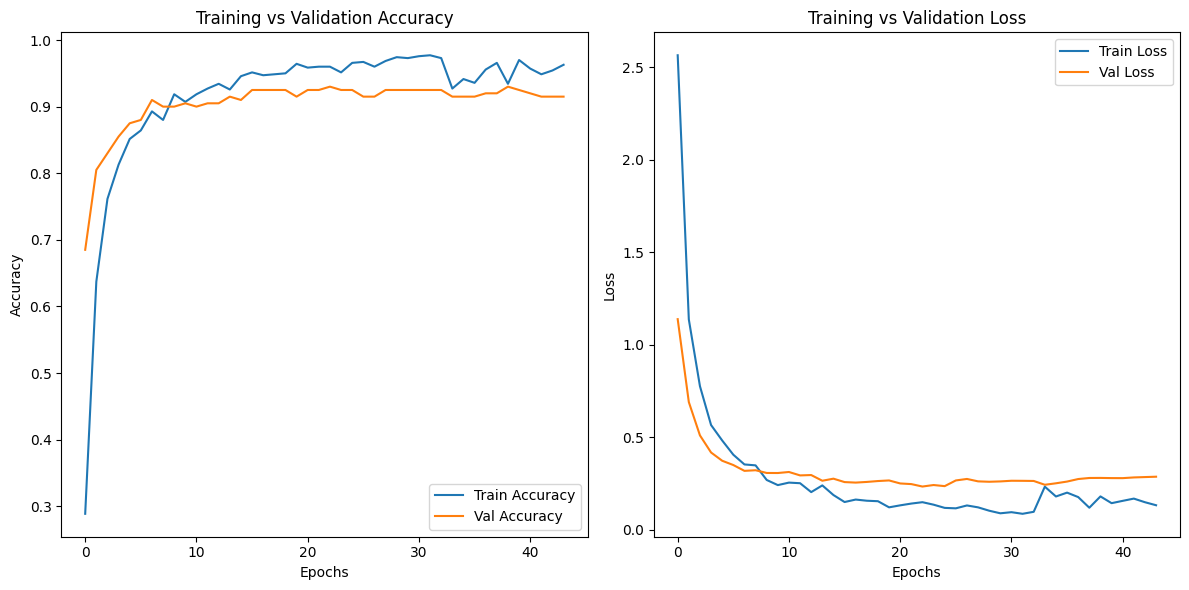

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


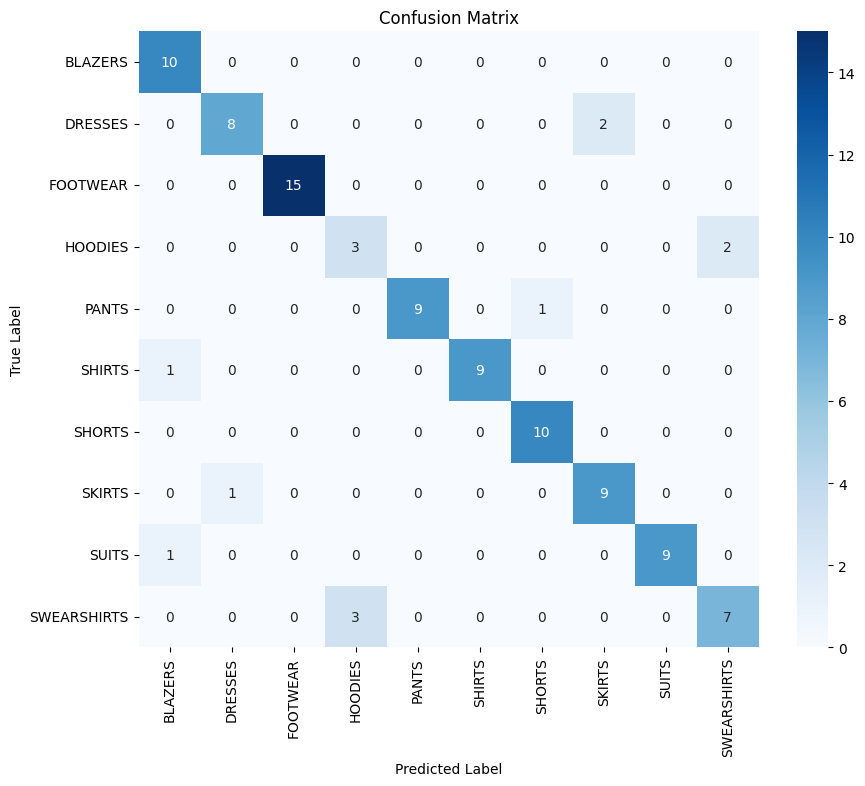

              precision    recall  f1-score   support

     BLAZERS       0.83      1.00      0.91        10
     DRESSES       0.89      0.80      0.84        10
    FOOTWEAR       1.00      1.00      1.00        15
     HOODIES       0.50      0.60      0.55         5
       PANTS       1.00      0.90      0.95        10
      SHIRTS       1.00      0.90      0.95        10
      SHORTS       0.91      1.00      0.95        10
      SKIRTS       0.82      0.90      0.86        10
       SUITS       1.00      0.90      0.95        10
 SWEARSHIRTS       0.78      0.70      0.74        10

    accuracy                           0.89       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.90      0.89      0.89       100



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Classification Report
print(classification_report(y_test, y_pred, target_names=class_names))

In [19]:
model.save('/content/drive/My Drive/Collab Notebooks/fashion_product_resnet50_finetuned.h5')

In [20]:
!pip install gradio --quiet
import gradio as gr

def predict_fashion(img):
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    return f"Predicted: {predicted_class}"

gr.Interface(
    fn=predict_fashion,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Fashion Classifier (ResNet50)",
    description="Upload a fashion image and get its category."
).launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aec3dc1191899ab59c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [21]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import numpy as np

# Predict probabilities
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Convert probabilities to predicted class labels
train_preds_class = np.argmax(train_preds, axis=1)
val_preds_class = np.argmax(val_preds, axis=1)
test_preds_class = np.argmax(test_preds, axis=1)

# True labels (assuming already integers)
y_train_class = y_train
y_val_class = y_val
y_test_class = y_test

# AUC Scores
train_auc = roc_auc_score(y_train, train_preds, multi_class='ovr')
val_auc = roc_auc_score(y_val, val_preds, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_preds, multi_class='ovr')

# Accuracy
train_accuracy = np.mean(train_preds_class == y_train_class)
val_accuracy = np.mean(val_preds_class == y_val_class)
test_accuracy = np.mean(test_preds_class == y_test_class)

# Loss
train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Precision, Recall, F1-Score (Weighted & Macro)
precision_weighted = precision_score(y_test_class, test_preds_class, average='weighted')
recall_weighted = recall_score(y_test_class, test_preds_class, average='weighted')
f1_weighted = f1_score(y_test_class, test_preds_class, average='weighted')

precision_macro = precision_score(y_test_class, test_preds_class, average='macro')
recall_macro = recall_score(y_test_class, test_preds_class, average='macro')
f1_macro = f1_score(y_test_class, test_preds_class, average='macro')

# Sensitivity = Recall (Weighted)
sensitivity = recall_weighted

# Specificity (approximate for multiclass): TN / (TN + FP) averaged
conf_matrix = confusion_matrix(y_test_class, test_preds_class)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
specificity = np.mean(TN / (TN + FP))

# Classification Miss Rate
miss_rate = 1 - sensitivity

# Output all metrics
print(f"🔹 AUC - Train: {train_auc:.4f}, Validation: {val_auc:.4f}, Test: {test_auc:.4f}")
print(f"🔹 Accuracy - Train: {train_accuracy:.4f}, Validation: {val_accuracy:.4f}, Test: {test_accuracy:.4f}")
print(f"🔹 Loss - Train: {train_loss:.4f}, Validation: {val_loss:.4f}, Test: {test_loss:.4f}")
print(f"🔹 Precision (Weighted): {precision_weighted:.4f}, (Macro): {precision_macro:.4f}")
print(f"🔹 Recall (Sensitivity) (Weighted): {recall_weighted:.4f}, (Macro): {recall_macro:.4f}")
print(f"🔹 F1-Score (Weighted): {f1_weighted:.4f}, (Macro): {f1_macro:.4f}")
print(f"🔹 Specificity (approx): {specificity:.4f}")
print(f"🔹 Classification Miss Rate: {miss_rate:.4f}")
print("\n🔹 Confusion Matrix:\n", conf_matrix)
print("\n🔹 Classification Report:\n", classification_report(y_test_class, test_preds_class))


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 706ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
🔹 AUC - Train: 0.9998, Validation: 0.9953, Test: 0.9847
🔹 Accuracy - Train: 0.9871, Validation: 0.9150, Test: 0.8900
🔹 Loss - Train: 0.0377, Validation: 0.2431, Test: 0.3505
🔹 Precision (Weighted): 0.8977, (Macro): 0.8727
🔹 Recall (Sensitivity) (Weighted): 0.8900, (Macro): 0.8700
🔹 F1-Score (Weighted): 0.8912, (Macro): 0.8685
🔹 Specificity (approx): 0.9880
🔹 Classification Miss Rate: 0.1100

🔹 Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  2  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  2]
 [ 0  0  0  0  9  0  1  0  0  0]
 [ 1  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  1  0  0  0  0  0  9  0  0]
 [ 1  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  3  0  0  0  0  0  7]]

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10

In [22]:
from sklearn.metrics import (
    confusion_matrix, fbeta_score, precision_score, recall_score, f1_score
)
import numpy as np

# Predict classes
test_preds = model.predict(X_test)
test_preds_class = np.argmax(test_preds, axis=1)
y_true = y_test  # assumed to be integer-encoded

# Confusion Matrix
cm = confusion_matrix(y_true, test_preds_class)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Small value to prevent divide-by-zero
eps = 1e-10

# F2-Score (beta=2)
f2_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=2)

# Fβ-Score for general beta (set your desired beta)
beta = 0.5
f_beta_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=beta)

# Positive Predictive Value (Precision)
ppv = precision_score(y_true, test_preds_class, average='weighted')

# Negative Predictive Value (NPV)
npv = np.mean(TN / (TN + FN + eps))

# False Positive Rate (FPR)
fpr = np.mean(FP / (FP + TN + eps))

# False Negative Rate (FNR)
fnr = np.mean(FN / (FN + TP + eps))

# Likelihood Ratios
sensitivity = recall_score(y_true, test_preds_class, average='weighted')
specificity = np.mean(TN / (TN + FP + eps))

lr_positive = sensitivity / (1 - specificity + eps)
lr_negative = (1 - sensitivity) / (specificity + eps)

# Fowlkes–Mallows Index (FMI)
precision_macro = precision_score(y_true, test_preds_class, average='macro')
recall_macro = recall_score(y_true, test_preds_class, average='macro')
fmi = np.sqrt(precision_macro * recall_macro)

# Print Results
print(f"🔹 F2-Score (Weighted): {f2_score_weighted:.4f}")
print(f"🔹 F{beta}-Score (Weighted): {f_beta_score_weighted:.4f}")
print(f"🔹 Positive Predictive Value (PPV): {ppv:.4f}")
print(f"🔹 Negative Predictive Value (NPV): {npv:.4f}")
print(f"🔹 False Positive Rate (FPR): {fpr:.4f}")
print(f"🔹 False Negative Rate (FNR): {fnr:.4f}")
print(f"🔹 Likelihood Ratio Positive (LR+): {lr_positive:.4f}")
print(f"🔹 Likelihood Ratio Negative (LR−): {lr_negative:.4f}")
print(f"🔹 Fowlkes–Mallows Index (FMI): {fmi:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
🔹 F2-Score (Weighted): 0.8898
🔹 F0.5-Score (Weighted): 0.8945
🔹 Positive Predictive Value (PPV): 0.8977
🔹 Negative Predictive Value (NPV): 0.9880
🔹 False Positive Rate (FPR): 0.0120
🔹 False Negative Rate (FNR): 0.1300
🔹 Likelihood Ratio Positive (LR+): 73.8786
🔹 Likelihood Ratio Negative (LR−): 0.1113
🔹 Fowlkes–Mallows Index (FMI): 0.8714
